In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Setup
Let $x \sim \mathcal{N}(\mu, 1) = p(x; \mu)$. Suppose we wish to optimize
\begin{align}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator{\V}{\mathbb{Var}}
\mu^* &= \argmin_\mu \E_{x \sim p(x;\mu)}[x^2] \\ 
&= \argmin_\mu \mathcal{L}(\mu).
\end{align}
Note, the parameters are in the sampling distribution, as it often occurs in Variational Inference. That is, we wish to tune the parameters of the distribution, such that the expectation is minimized. For this example the minimum occurs at $\mu^* = 0$. Also note that $E[x^2] = \V[x] + E[x]^2 = 1 + \mu^2$.

In the following, stochastic gradient-based optimization using Monte Carlo samples will be applied. That is, we seek to find
$$
\nabla_{\!\mu} \mathcal{L}(\mu)
$$
analytically. Once obtained, we approximate the expection via Monte Carlo sampling. We then update our current best estimate $\hat{\mu}^{(t)}$ via
$$\hat{\mu}^{(t+1)} = \hat{\mu}^{(t)} - \alpha \nabla_{\!\mu} \mathcal{L}(\mu^{(t)}),$$
where $\alpha$ is the learning rate.



## Strategies
In particular, two methods for computing the gradients will be evaluated: score function gradients and reparametrized gradients. 

In [64]:
import matplotlib.transforms as transforms

def run_ntimes(fn, runs=50, **kwargs):
    losses = np.array([fn(**kwargs) for _ in range(runs)])
    return losses

def plot_convergence(losses, label=None, ax=None):
    if ax is None:
        ax = plt.gca()
        
    mean, std = losses.mean(0), losses.std(0)
    upper_bound = mean + 2*std
    lower_bound = mean - 2*std
    lower_bound = np.clip(lower_bound, 1, None)    
    
    ax.axhline(y=1, color='red')
    ax.plot(np.arange(losses.shape[1]), mean, label=f'{label} - mean')
    ax.fill_between(np.arange(losses.shape[1]), lower_bound, upper_bound, alpha=0.5, label=f'{label} - +/-2$\sigma$')
    trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0, 1, 'True E'.format(mean), color="red", transform=trans, ha="right", va="center")
    
    return ax

# Common parameters for both methds
params = {
    'batch_size' : 5,
    'epochs': 50,
    'alpha' : 1e-1,
    'verbose' : False,
    'runs': 50
}

### Score Function Gradients

\begin{align}
\nabla_{\!\mu} \mathcal{L}(\mu) = \nabla_{\!\mu} \E_{x \sim p(x;\mu)}[x^2] &= \nabla_{\!\mu} \int_x x^2 p(x;\mu)\,dx\\
&= \int_x x^2 \nabla_{\!\mu} p(x;\mu) \,dx \\
&= \int_x x^2 \frac{p(x;\mu)}{p(x;\mu)} \nabla_{\!\mu} p(x;\mu) \,dx \\
&= \int_x x^2 p(x;\mu)\frac{\nabla_{\!\mu} p(x;\mu)}{p(x;\mu)}\,dx \\
&= \int_x x^2 p(x;\mu)\nabla_{\!\mu} \log p(x;\mu) \,dx \\
&= \E_{x \sim p(x;\mu)}\left[x^2\nabla_{\!\mu} \log p(x;\mu)\right].\\
\end{align}

The log trick allows us to write the gradient of an expection as an expectation of gradients. This way, approximation of the expectation via sampling is possible. We have $$\nabla_{\!\mu} \log \mathcal{N}(x; \mu, 1) = (x - \mu).$$Thus, $$ \E_{x \sim p(x;\mu)}\left[x^2\nabla_{\!\mu} \log p(x;\mu)\right] = \E_{x \sim p(x;\mu)}\left[x^2(x-\mu) \right] $$

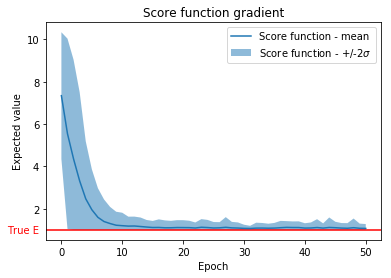

In [65]:
def e_x2(mu):
    '''Compute the expectation of E(x**2) where x ~ N(mu, 1).'''    
    return mu**2 + 1 

def minimize_sfg(batch_size=10, epochs=200, alpha=1e-1, verbose=True):
    mu = np.random.uniform(2,3)
    losses = []
    losses.append(e_x2(mu)) # actually expectation of non-central chi-squared.
    for e in range(epochs):
        x = np.random.normal(mu, 1, size=batch_size)
        score_grad = (np.square(x) * (x - mu)).mean()
        mu += - alpha * score_grad
        losses.append(e_x2(mu))
        if verbose and ((e+1) % (epochs//10) == 0):
            print(e, e_x2(mu))
    return losses

losses_score = run_ntimes(minimize_sfg, **params)
fig, ax = plt.subplots()
plot_convergence(losses_score, 'Score function')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Expected value')
plt.title('Score function gradient')
plt.legend()

### LOTUS / Reparametrization Trick / Integrated Paths

The reparametrization trick uses LOTUS backwards. To remove the parameters from the distributin $p(x;\mu)$, we assume that we are able to find another distribution $\lambda \sim \pi(\lambda)$, independent of $\mu$, such that $x \sim p(x;\mu) = g(\lambda; \mu), \lambda \sim \pi(\lambda)$, for some function $g$. Assuming that we can find $\pi(\lambda)$ and $g$, we can rewrite $ \nabla_{\!\mu} \mathcal{L}(\mu)$ as follows

\begin{align}
    \nabla_{\!\mu} \mathcal{L}(\mu) = \nabla_{\!\mu} \E_{x \sim p(x;\mu)}[x^2] &= \nabla_{\!\mu} \E_{\lambda \sim \pi(\lambda)}[g(\lambda;\mu)^2]\\
    &= \int_\lambda \pi(\lambda) \nabla_{\!\mu} g(\lambda;\mu)^2  \,d\lambda \\
    &= \E_{\lambda \sim \pi(\lambda)}\left[\nabla_{\!\mu} g(\lambda;\mu)^2\right].
\end{align}

In our case we let $\pi(\lambda) = \mathcal{N}(\lambda;0,1)$ standard normal and define $g(\lambda;\mu) = \lambda + \mu$. Using the chain rule 
\begin{align}
    \E_{\lambda \sim \pi(\lambda)}\left[\nabla_{\!\mu} g(\lambda;\mu)^2\right] &= \E_{\lambda \sim \pi(\lambda)}\left[2g(\lambda;\mu)\right]\\
    &= \E_{\lambda \sim \pi(\lambda)}\left[2(\lambda + \mu)\right]
\end{align}

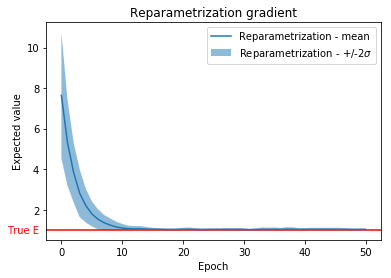

In [66]:
def minimize_reprtrick(batch_size=10, epochs=200, alpha=1e-1, verbose=True):
    mu = np.random.uniform(2,3)
    losses = []
    losses.append(e_x2(mu))
    for e in range(epochs):
        x = np.random.normal(size=batch_size) # standard normal
        grad = (2*(x + mu)).mean()
        mu += - alpha * grad
        losses.append(e_x2(mu))
        if verbose and ((e+1) % (epochs//10) == 0):
            print(e, e_x2(mu))
    return losses

losses_repr = run_ntimes(minimize_reprtrick, **params)
fig, ax = plt.subplots()
plot_convergence(losses_repr, 'Reparametrization')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Expected value')
plt.title('Reparametrization gradient')
plt.legend()

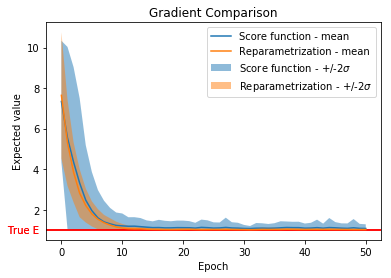

In [68]:
fig, ax = plt.subplots()
plot_convergence(losses_score, 'Score function')
plot_convergence(losses_repr, 'Reparametrization')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Expected value')
plt.title('Gradient Comparison')
plt.legend()